In [1]:
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [11]:
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

In [3]:
def load_and_transform_df(data_file):
    df = pd.read_csv(data_file) 
    df = df.drop(columns= ['Unnamed: 0'])

    mapping_dict = {
    "Центральный федеральный округ": "ЦФО",
    "Приволжский федеральный округ": "ПФО",
    "Дальневосточный федеральный округ": "ДФО",
    "Северо-Западный федеральный округ": "СЗФО",
    "Сибирский федеральный округ": "СФО",
    "Южный федеральный округ": "ЮФО",
    "Северо-Кавказский федеральный округ": "СКФО",
    "Уральский федеральный округ": "УФО"
    }

    df["Округ"] = df["Округ"].map(mapping_dict)

    # столбец добавляется для создания иерархии
    df["Округ_Область"] = df.apply(lambda x: f"{x['Округ']}_{x['Область']}", axis=1)
    
    df['Кол-во'] = df['Кол-во']/1000 #отображение в сотнях тысяч
    
    return df

def create_hierarchy_df(df, is_q=True):  
    # нижний уровень
    df_bottom_level = df.pivot(index="Год", columns="Округ_Область", values="Кол-во")

    #средний уровень
    df_middle_level = df.groupby(["Год", "Округ"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="Год", columns="Округ", values="Кол-во")

    # верхний уровень
    df_total = df.groupby("Год")["Кол-во"] \
             .sum() \
             .to_frame() \
             .rename(columns={"Кол-во": "total"})

    # соединение
    hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
    if is_q:
        hierarchy_df.index = pd.to_datetime(hierarchy_df.index, format="%d.%m.%Y")
        hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()
    else:
        hierarchy_df.index = pd.to_datetime(hierarchy_df.index, format="%Y")
        hierarchy_df = hierarchy_df.resample("YS") \
                           .sum()
    
    hierarchy_df.fillna(0, inplace=True)
    
    return hierarchy_df

def create_hierarchy(df):   
    # создание иерархии
    districts = df["Округ"].unique()
    regions = df["Округ_Область"].unique()

    total = {'total': list(districts)}
    state = {k: [v for v in regions if v.startswith(k)] for k in districts}
    hierarchy = {**total, **state}
    
    return hierarchy

In [40]:
steps_ahead = 2

def plot_results(pred_df, source_df, cols_to_plot, mae, forecasts):
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        print(f'MAE {col}:', round(mae[col], 2))
        print(f'Прогнозы {col}:', round(forecasts[col], 2))
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Прогноз")
        source_df[col].plot(ax=ax, label="Наблюдение")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Дата")
        ax.set_ylabel("Численность в сотнях тысяч")

def get_mae(pred_df, source_df, steps_ahead):
    drop_pred = pred_df.drop(pred_df.tail(steps_ahead).index, inplace=False)
    residuals_abs = abs(drop_pred - source_df)
    return residuals_abs.mean()

def get_forecasts(pred_df, steps_ahead):
    return pred_df.tail(steps_ahead)

def experiment(hierarchy_df, hierarchy, steps_ahead, model, approach, levels):
    model = hts.HTSRegressor(model=model, revision_method=approach, n_jobs=0)
    model = model.fit(hierarchy_df, hierarchy)
    pred = model.predict(steps_ahead=steps_ahead)
    mae = get_mae(pred, hierarchy_df, steps_ahead)
    forecasts = get_forecasts(pred, steps_ahead)
    
    for level in levels:
        plot_results(pred, hierarchy_df, level, mae, forecasts)

# Эксперименты с данными по годам

In [5]:
df_y = load_and_transform_df('data_y.csv')
hierarchy_df_y = create_hierarchy_df(df_y, is_q=False)
hierarchy = create_hierarchy(df_y)

<AxesSubplot:title={'center':'РФ'}, xlabel='Год'>

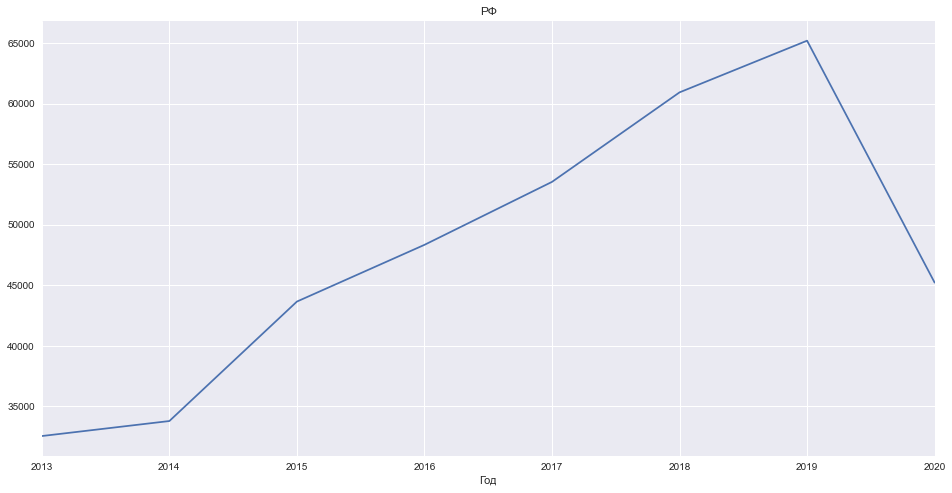

In [6]:
hierarchy_df_y["total"].plot(title="РФ")

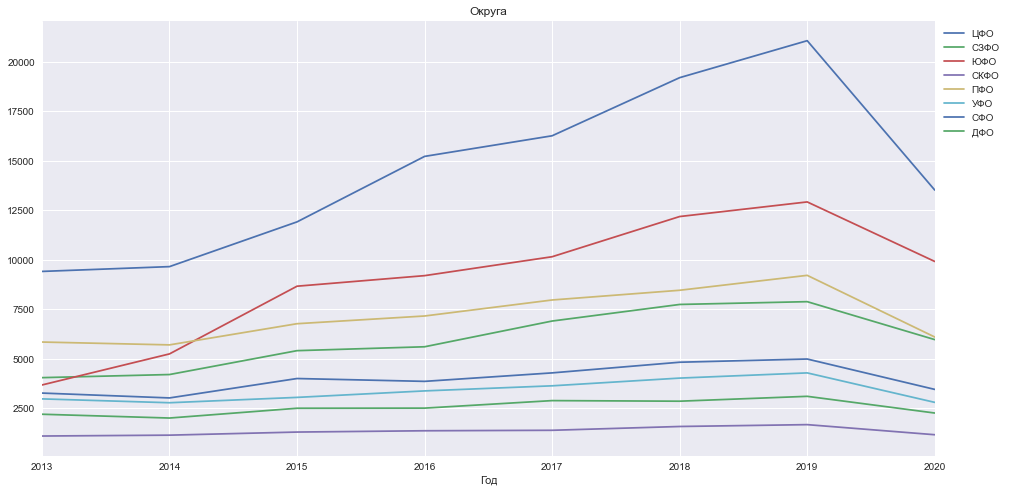

In [7]:
ax = hierarchy_df_y[hierarchy['total']].plot(title="Округа")
ax.legend(bbox_to_anchor=(1.0, 1.0));

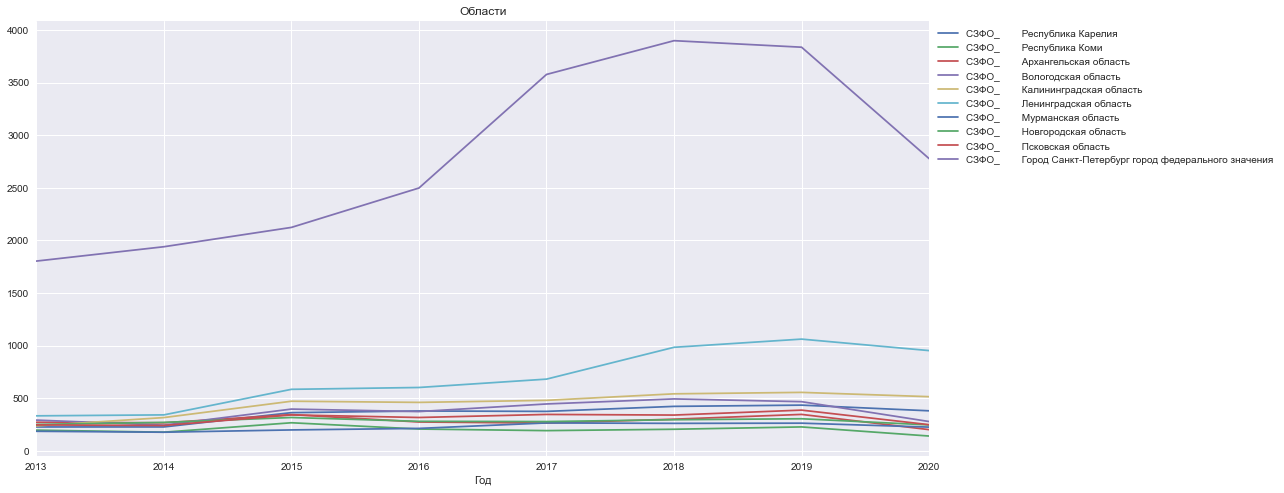

In [8]:
ax = hierarchy_df_y[hierarchy['СЗФО']].plot(title="Области")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## ARIMA

### Bottom-Up Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 213.09it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AF57CEE0>


MAE total: 6889.64
Прогнозы total: 2021-01-01    44891.15
2022-01-01    43155.20
Freq: AS-JAN, Name: total, dtype: float64
MAE СЗФО: 1988.28
Прогнозы СЗФО: 2021-01-01    3744.63
2022-01-01    3685.21
Freq: AS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 352.54
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2021-01-01    1855.66
2022-01-01    1549.11
Freq: AS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


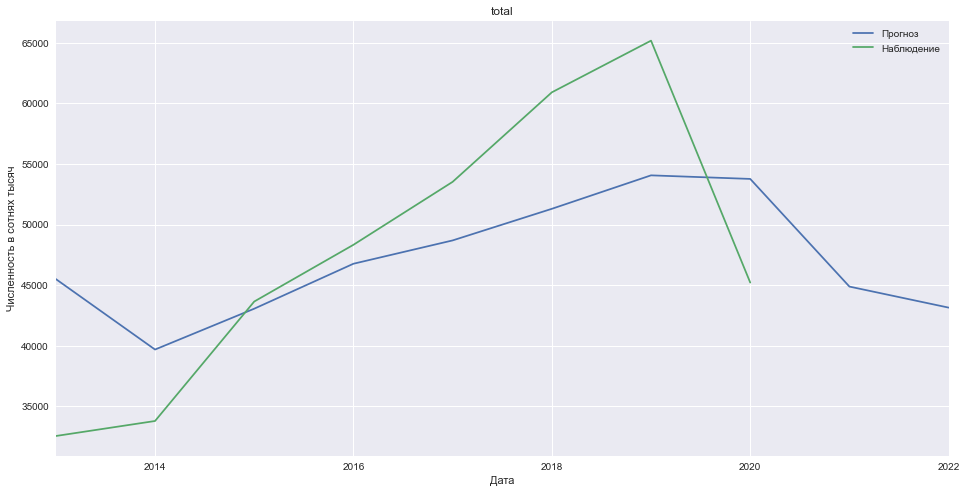

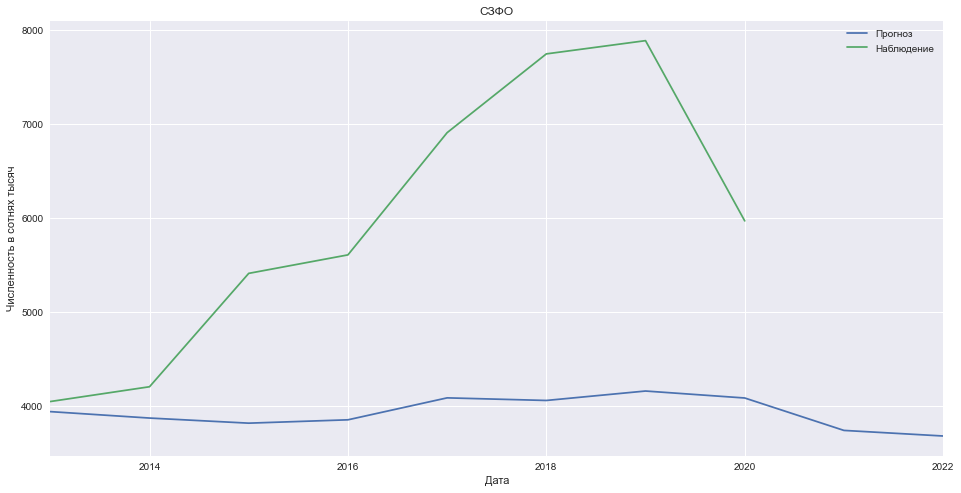

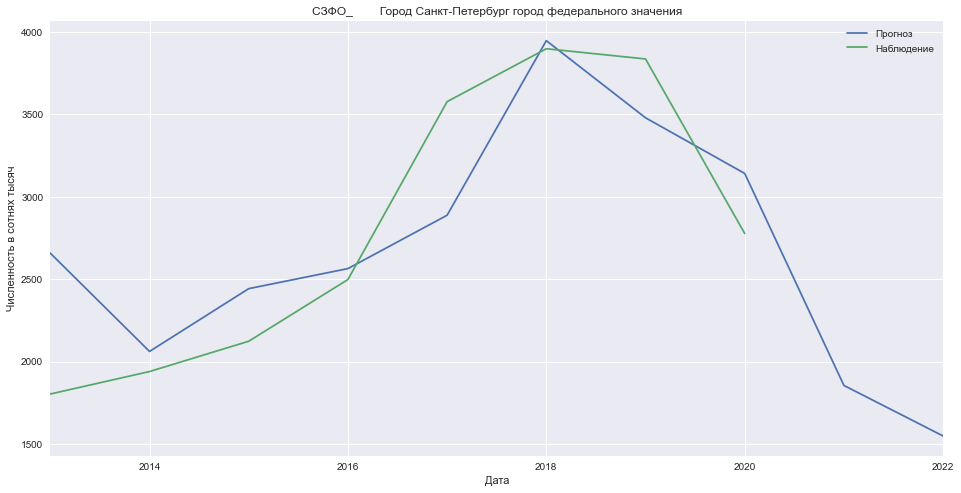

In [41]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'auto_arima', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 217.18it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217ABC80130>


MAE total: 6766.26
Прогнозы total: 2021-01-01    31271.60
2022-01-01    31950.44
Freq: AS-JAN, Name: total, dtype: float64
MAE СЗФО: 1800.43
Прогнозы СЗФО: 2021-01-01    2636.08
2022-01-01    2693.30
Freq: AS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 587.16
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2021-01-01    1814.43
2022-01-01    1853.82
Freq: AS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


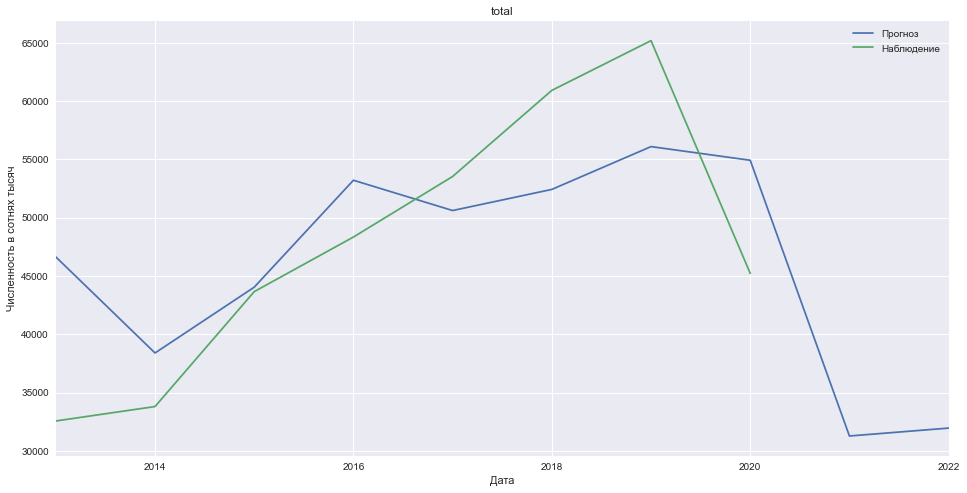

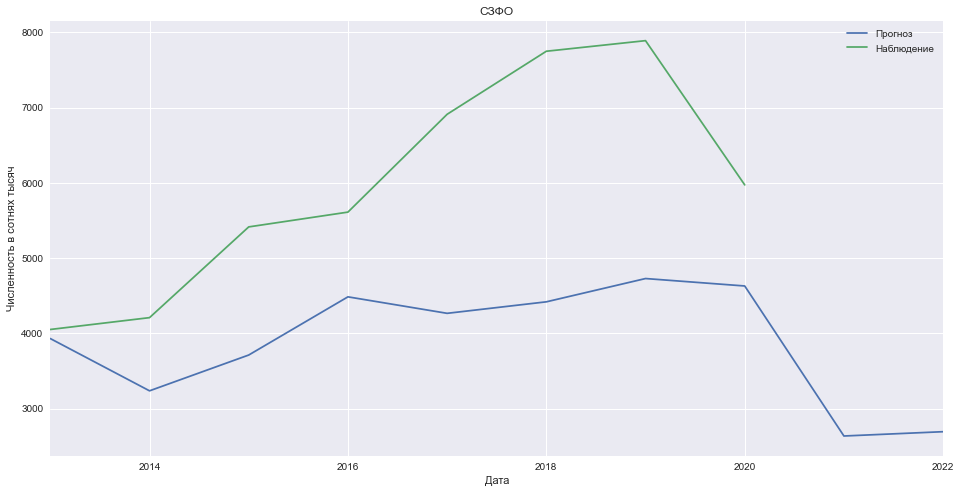

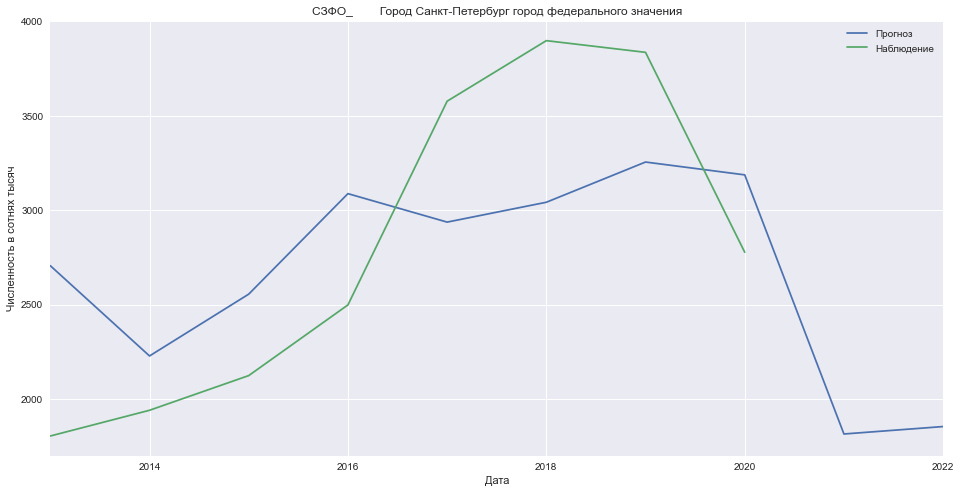

In [42]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'auto_arima', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach


Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 191.99it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AF78A4F0>


MAE total: 6745.77
Прогнозы total: 2021-01-01    38070.66
2022-01-01    37472.50
Freq: AS-JAN, Name: total, dtype: float64
MAE СЗФО: 1034.47
Прогнозы СЗФО: 2021-01-01    3736.97
2022-01-01    3431.40
Freq: AS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 342.38
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2021-01-01    1747.40
2022-01-01    1467.22
Freq: AS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


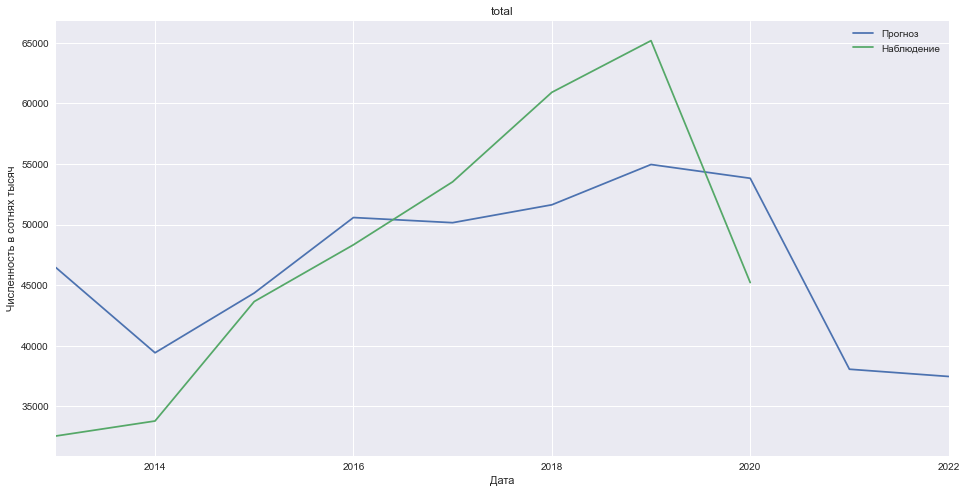

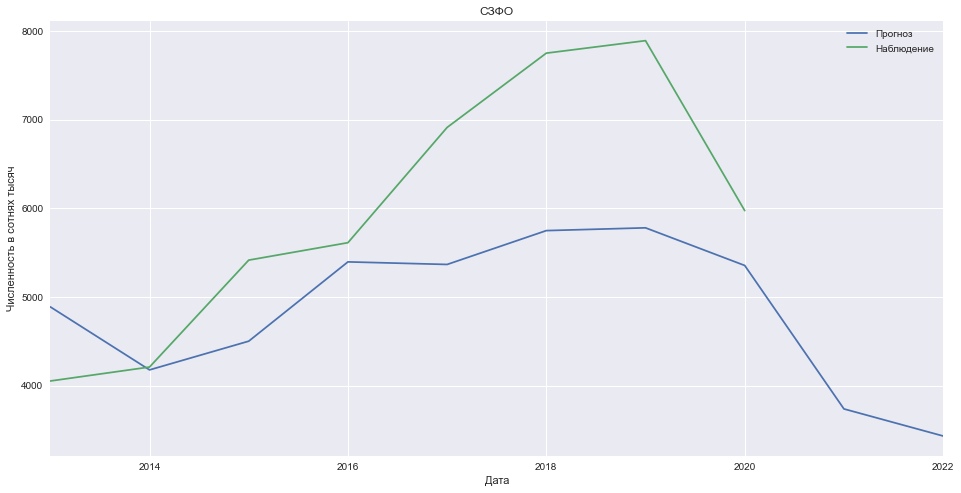

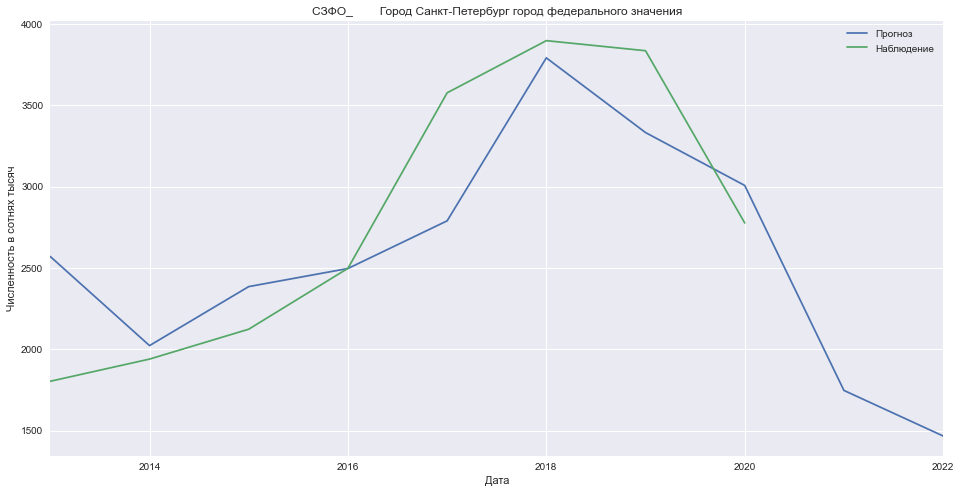

In [43]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'auto_arima', 'WLSS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

## Prophet

### Bottom-Up Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:51<00:00,  1.23s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AC03B250>


MAE total: 5682.37
Прогнозы total: 2021-01-01    67335.85
2022-01-01    70134.84
Freq: AS-JAN, Name: total, dtype: float64
MAE СЗФО: 2008.23
Прогнозы СЗФО: 2021-01-01    5115.62
2022-01-01    5346.82
Freq: AS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 294.21
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2021-01-01    4913.73
2022-01-01    5934.91
Freq: AS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


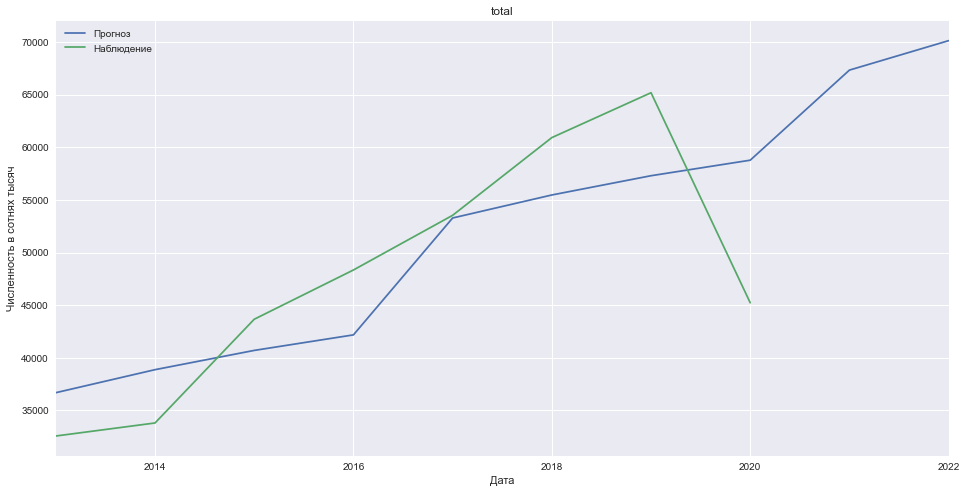

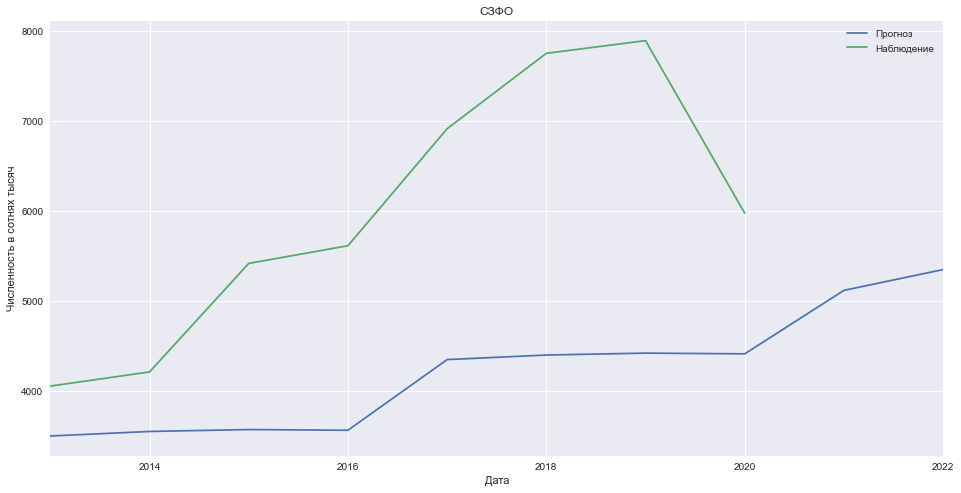

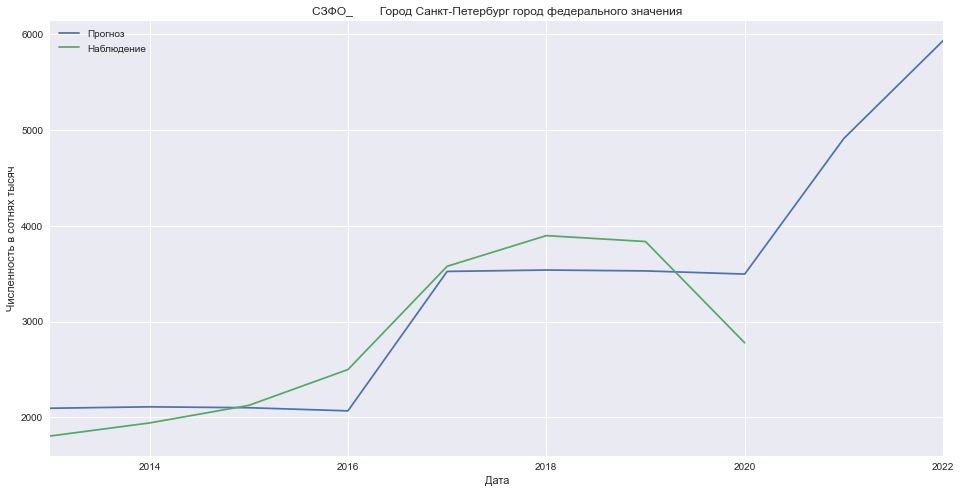

In [44]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'prophet', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:59<00:00,  1.31s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217ABC30250>


MAE total: 5703.74
Прогнозы total: 2021-01-01    67034.15
2022-01-01    68821.52
Freq: AS-JAN, Name: total, dtype: float64
MAE СЗФО: 1940.75
Прогнозы СЗФО: 2021-01-01    5650.73
2022-01-01    5801.40
Freq: AS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 406.73
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2021-01-01    3889.44
2022-01-01    3993.15
Freq: AS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


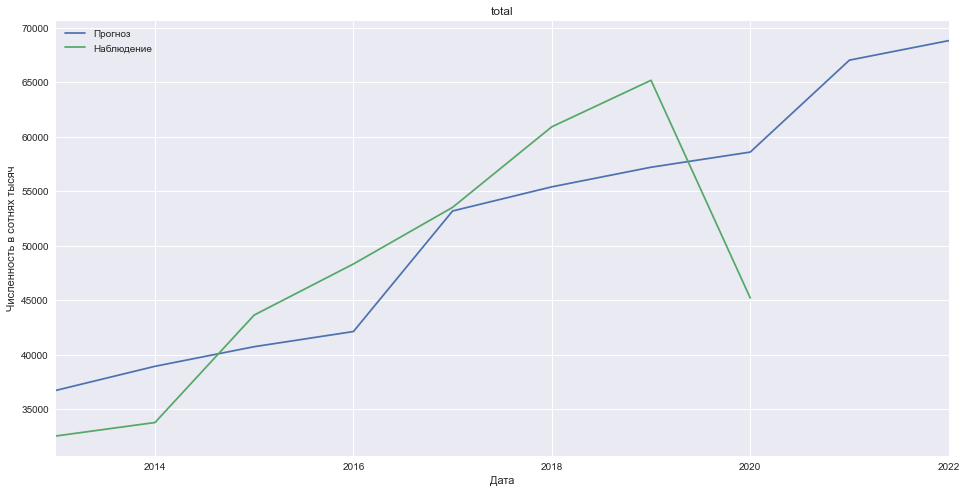

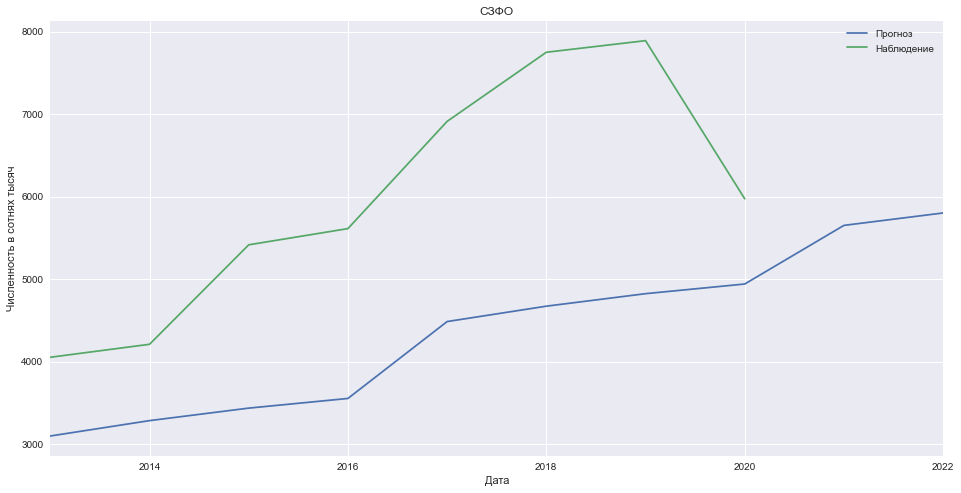

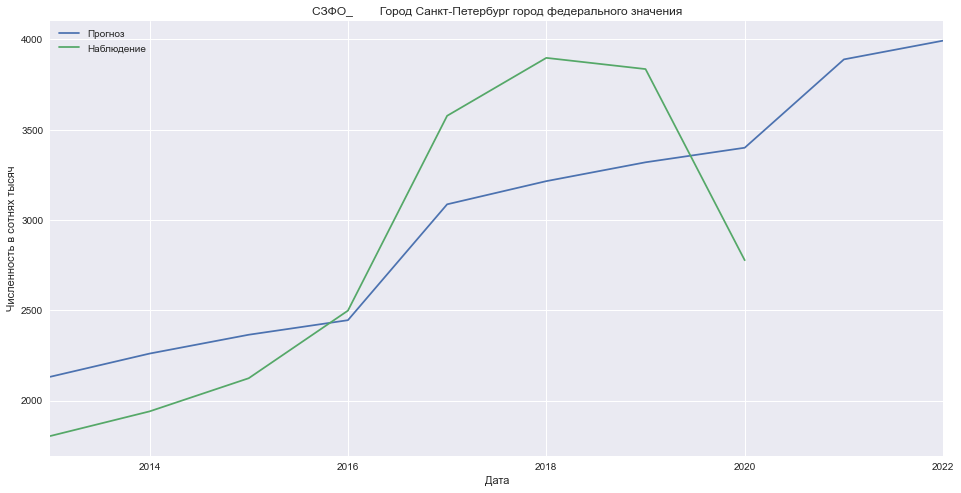

In [45]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'prophet', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:55<00:00,  1.27s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AD080B80>


MAE total: 5688.36
Прогнозы total: 2021-01-01    67194.13
2022-01-01    69392.11
Freq: AS-JAN, Name: total, dtype: float64
MAE СЗФО: 1006.03
Прогнозы СЗФО: 2021-01-01    6982.02
2022-01-01    7338.58
Freq: AS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 329.53
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2021-01-01    4723.17
2022-01-01    5716.25
Freq: AS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


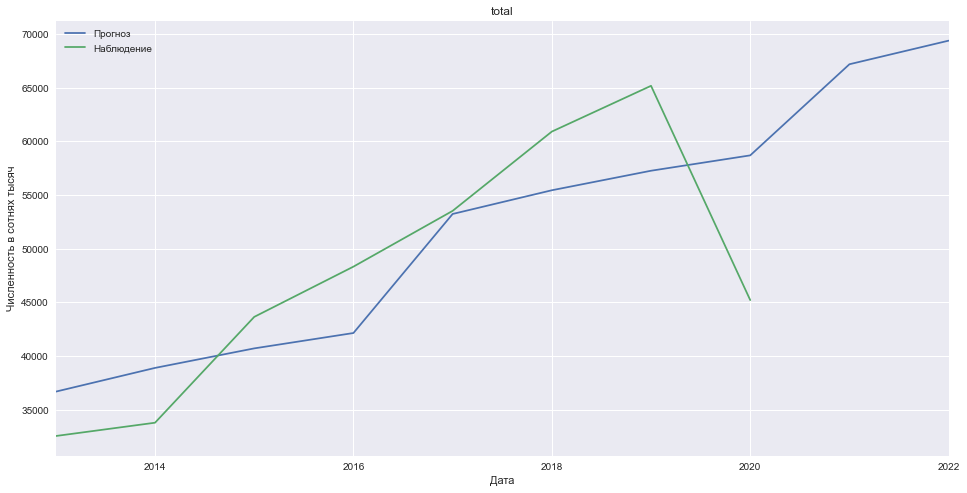

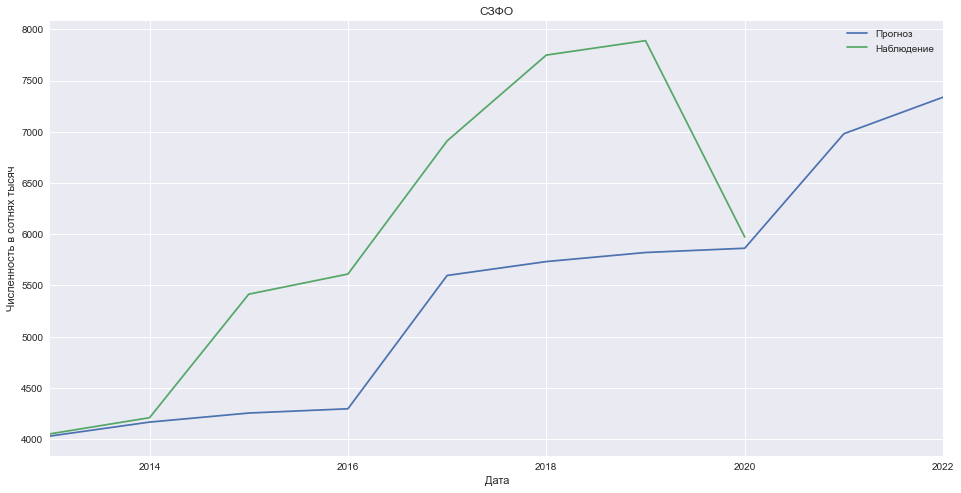

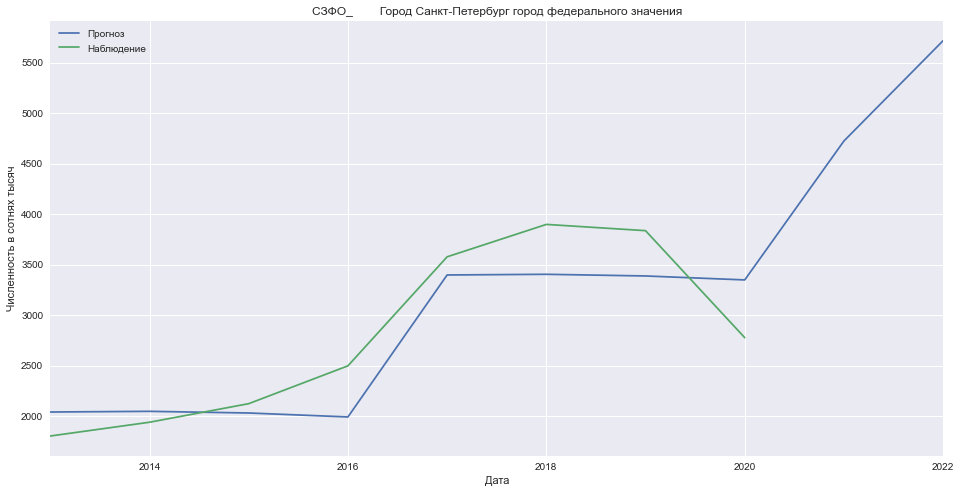

In [46]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'prophet', 'WLSS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

# Эксперименты с данными по кварталам

In [47]:
df_q = load_and_transform_df('data_q.csv')
hierarchy_df_q = create_hierarchy_df(df_q, is_q=True)

<AxesSubplot:title={'center':'РФ'}, xlabel='Год'>

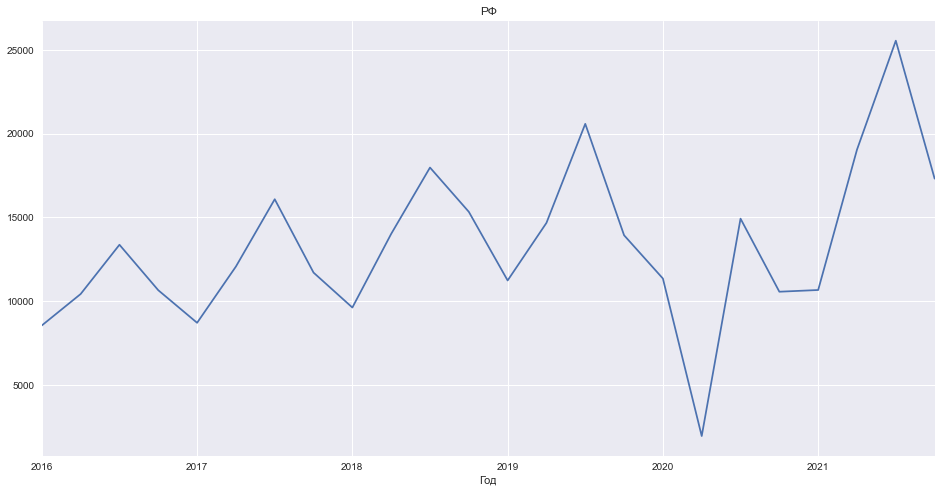

In [22]:
hierarchy_df_q["total"].plot(title="РФ")

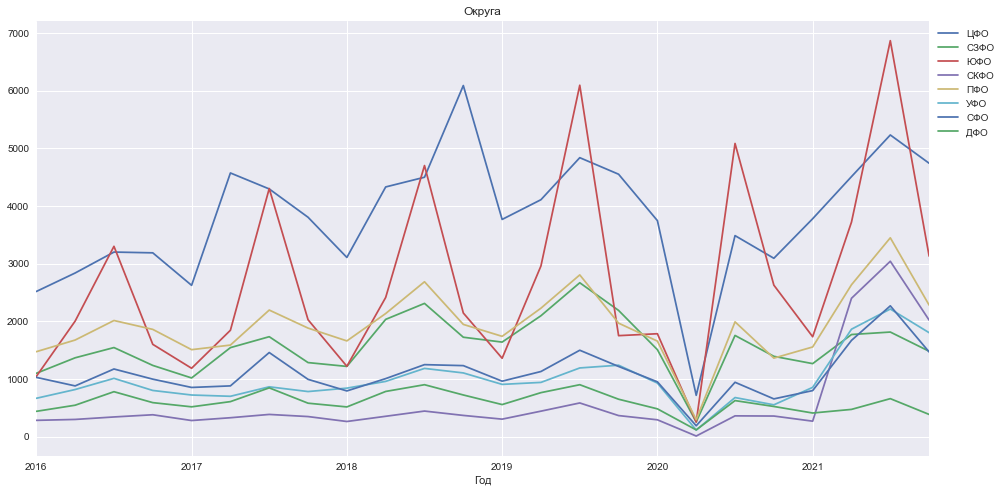

In [23]:
ax = hierarchy_df_q[hierarchy['total']].plot(title="Округа")
ax.legend(bbox_to_anchor=(1.0, 1.0));

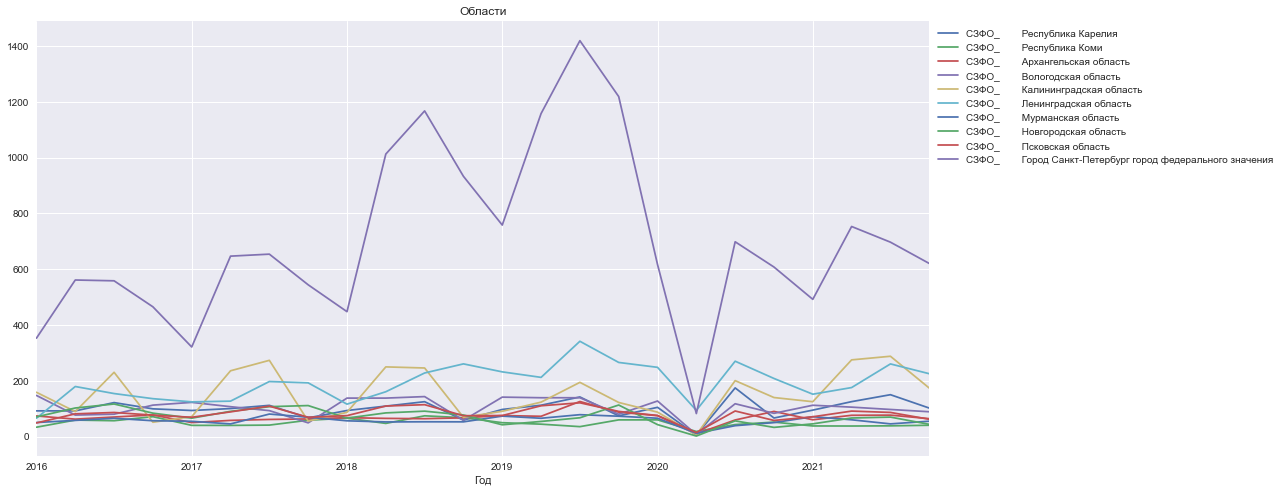

In [27]:
ax = hierarchy_df_q[hierarchy['СЗФО']].plot(title="Области")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## ARIMA

### Bottom-Up Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 240.08it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217ACE81280>


MAE total: 2807.02
Прогнозы total: 2022-01-01    14709.02
2022-04-01    12593.40
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 579.47
Прогнозы СЗФО: 2022-01-01    811.99
2022-04-01    497.50
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 201.62
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01    665.18
2022-04-01    695.17
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


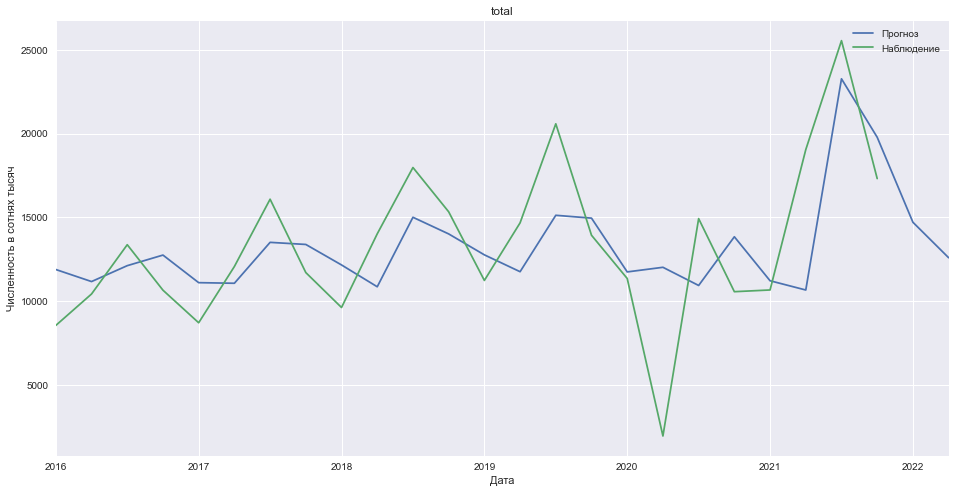

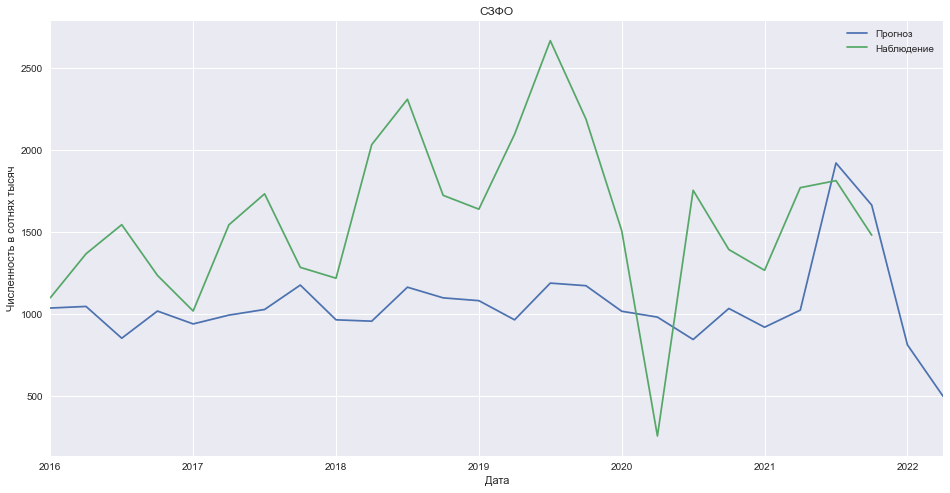

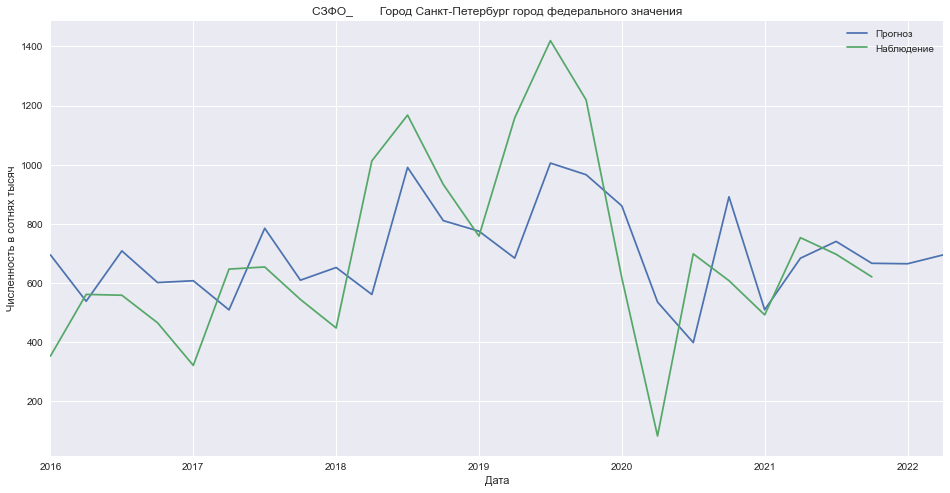

In [48]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'auto_arima', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 219.78it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AF9FA610>


MAE total: 3331.14
Прогнозы total: 2022-01-01    13414.28
2022-04-01    13316.38
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 539.07
Прогнозы СЗФО: 2022-01-01    1118.89
2022-04-01    1110.72
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 239.69
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01    701.91
2022-04-01    696.79
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


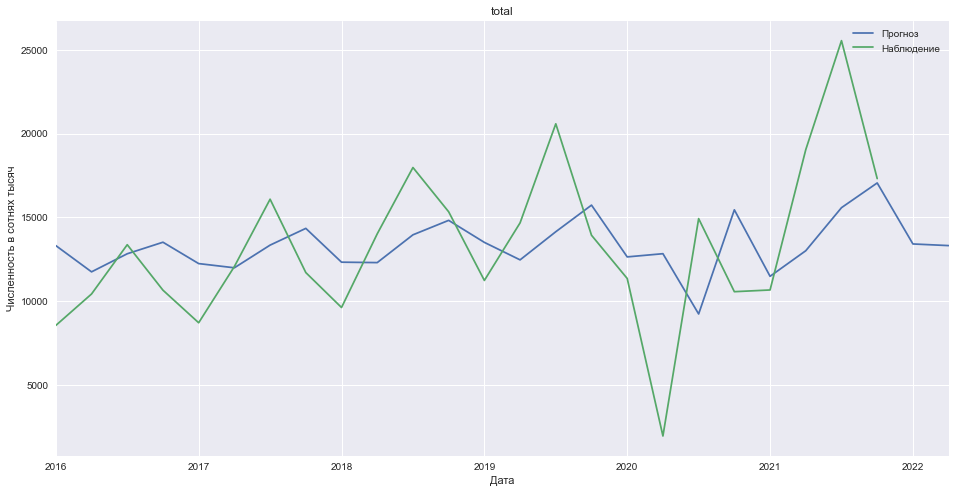

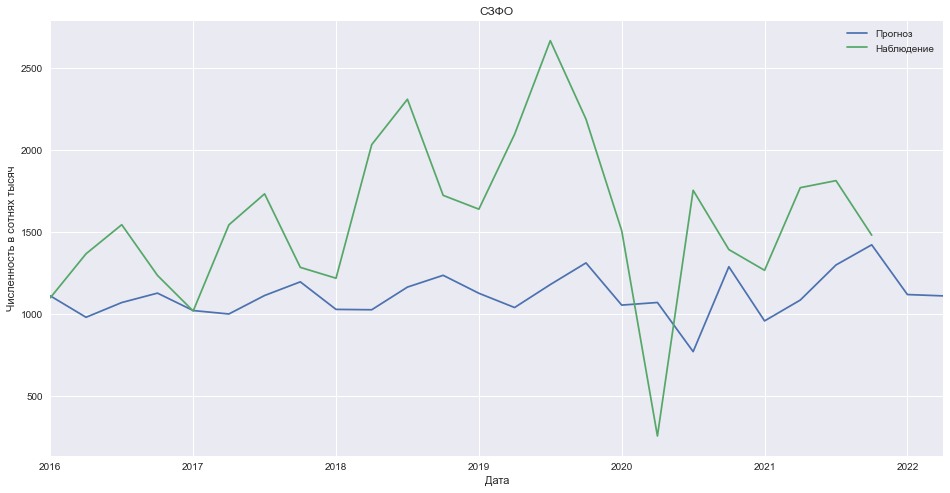

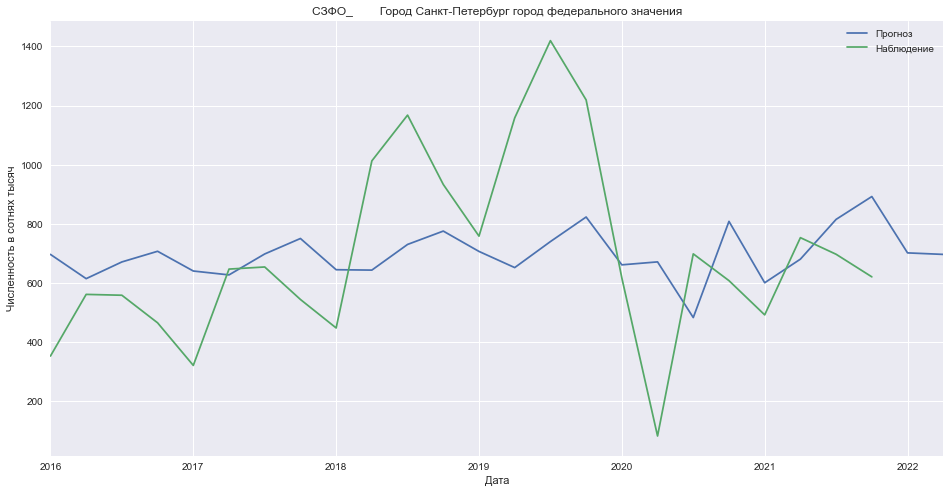

In [49]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'auto_arima', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 204.94it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217ACEDAD00>


MAE total: 2921.24
Прогнозы total: 2022-01-01    13471.33
2022-04-01    12502.62
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 406.38
Прогнозы СЗФО: 2022-01-01    1160.80
2022-04-01    1089.04
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 201.15
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01    641.53
2022-04-01    676.22
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


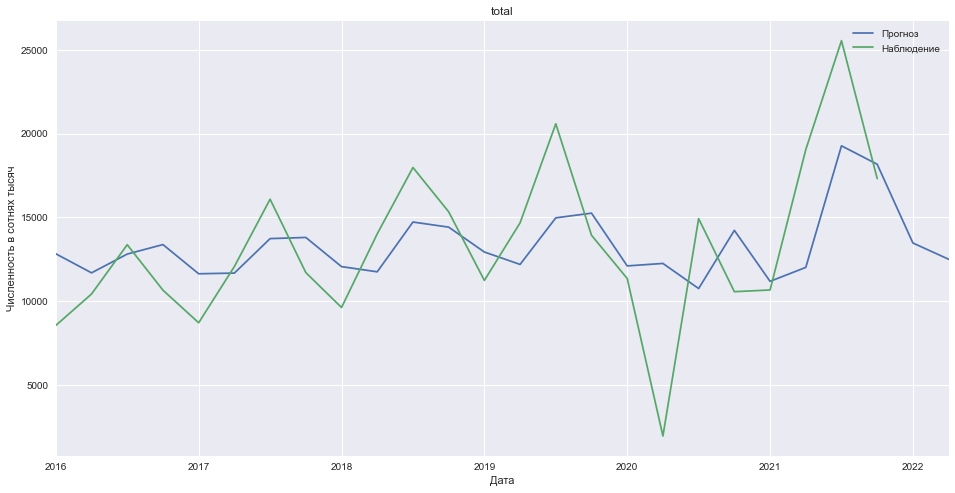

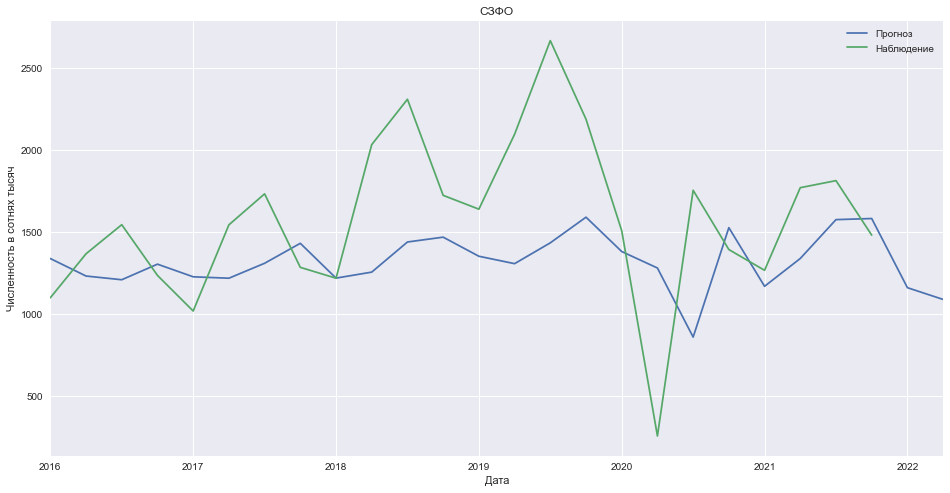

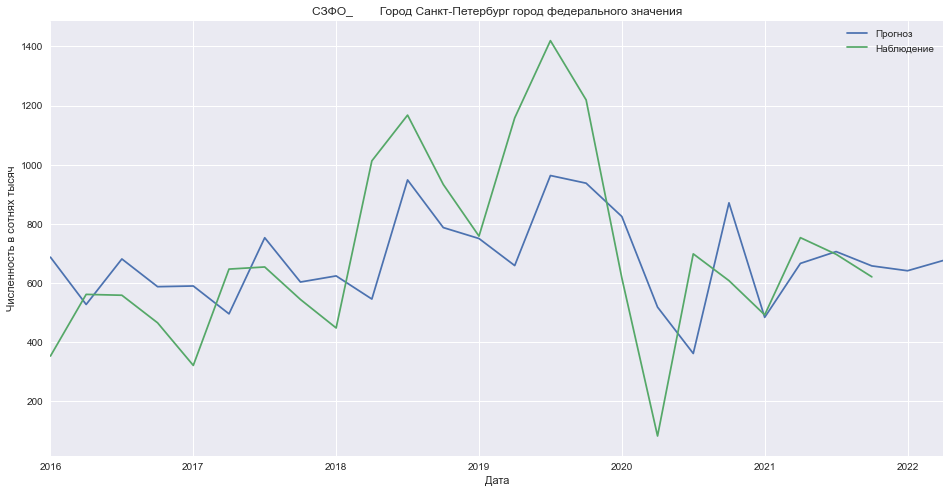

In [50]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'auto_arima', 'WLSS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

## SARIMAX

### Bottom-Up Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 352.72it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217ACFF9850>


MAE total: 4492.53
Прогнозы total: 2022-01-01    14973.9
2022-04-01    13067.6
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 764.58
Прогнозы СЗФО: 2022-01-01    1287.09
2022-04-01    1132.32
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 220.72
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01    565.72
2022-04-01    515.44
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


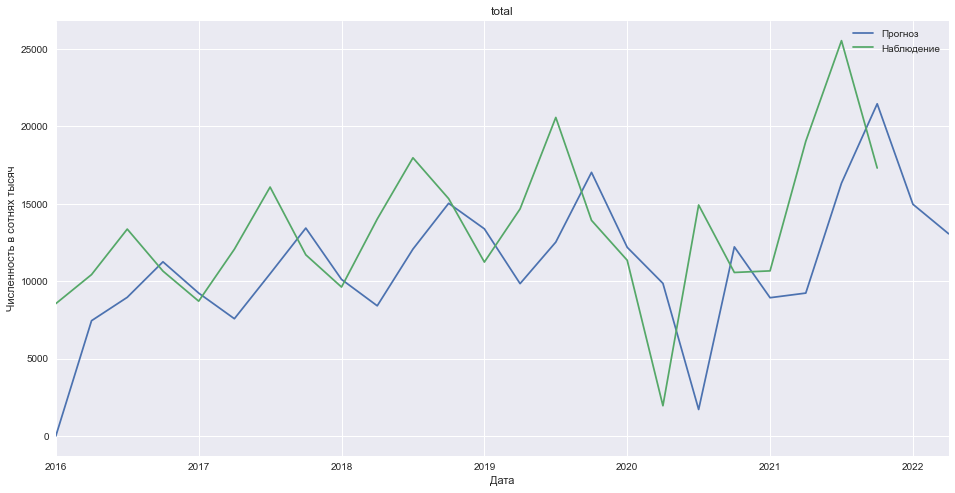

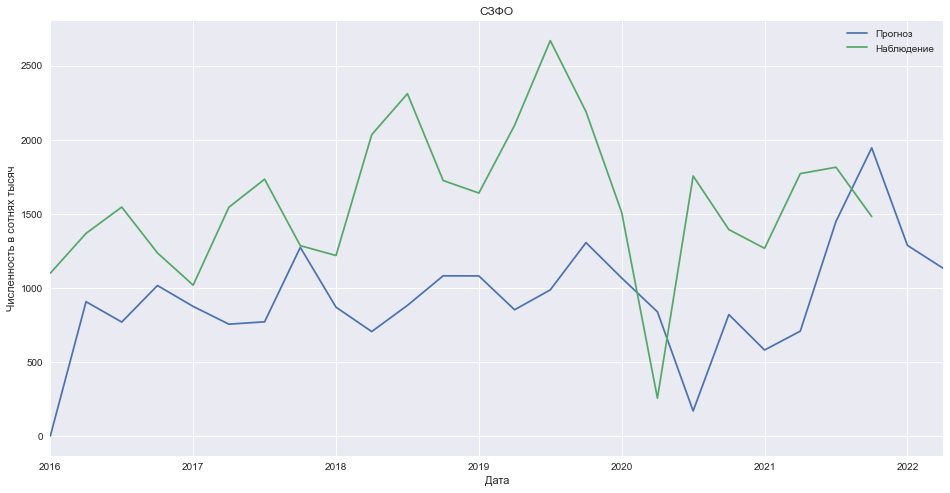

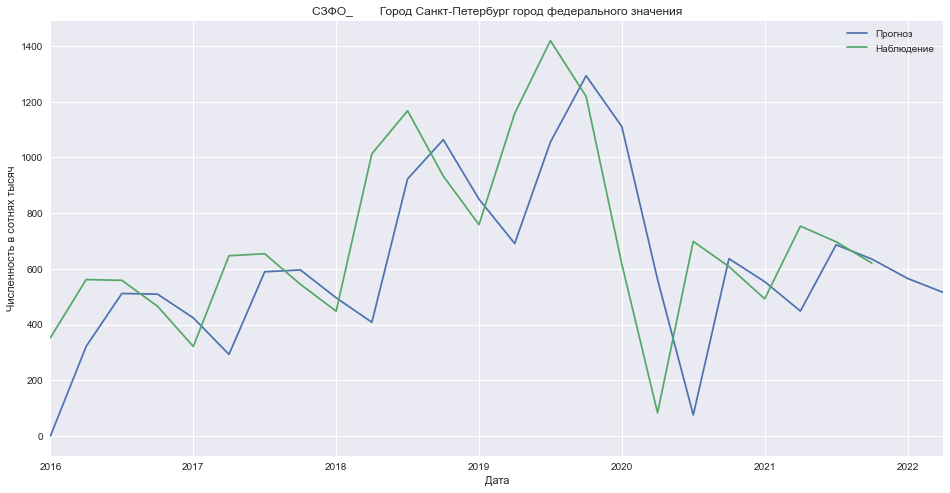

In [51]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'sarimax', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 328.53it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AEB8C490>


MAE total: 4683.01
Прогнозы total: 2022-01-01    15984.45
2022-04-01    14755.95
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 701.54
Прогнозы СЗФО: 2022-01-01    1333.27
2022-04-01    1230.80
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 274.14
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01    836.39
2022-04-01    772.11
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


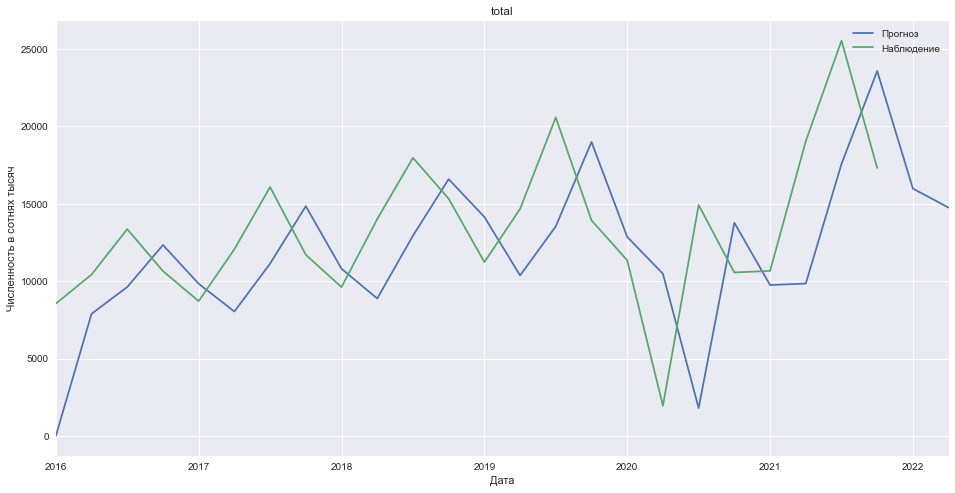

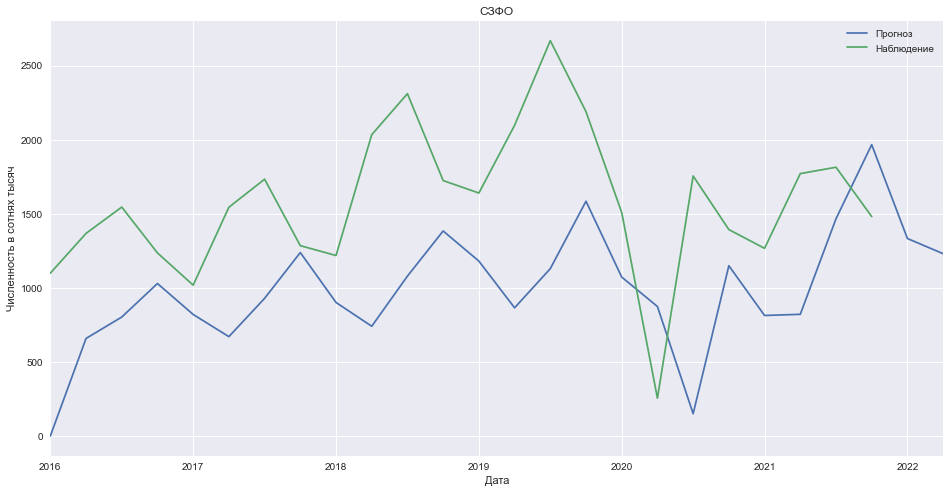

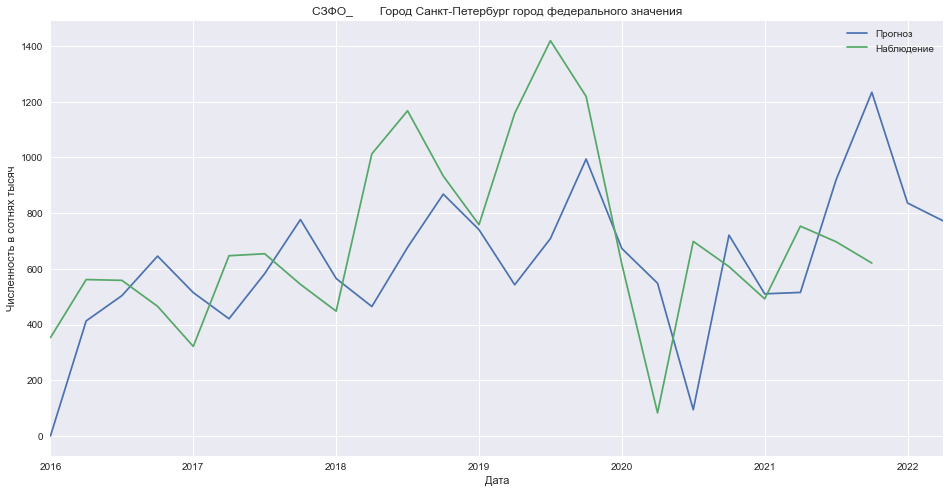

In [52]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'sarimax', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 333.33it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217ABB8B2E0>


MAE total: 4568.08
Прогнозы total: 2022-01-01    15495.55
2022-04-01    13957.31
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 528.3
Прогнозы СЗФО: 2022-01-01    1363.93
2022-04-01    1258.63
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 219.35
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01    570.96
2022-04-01    524.83
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


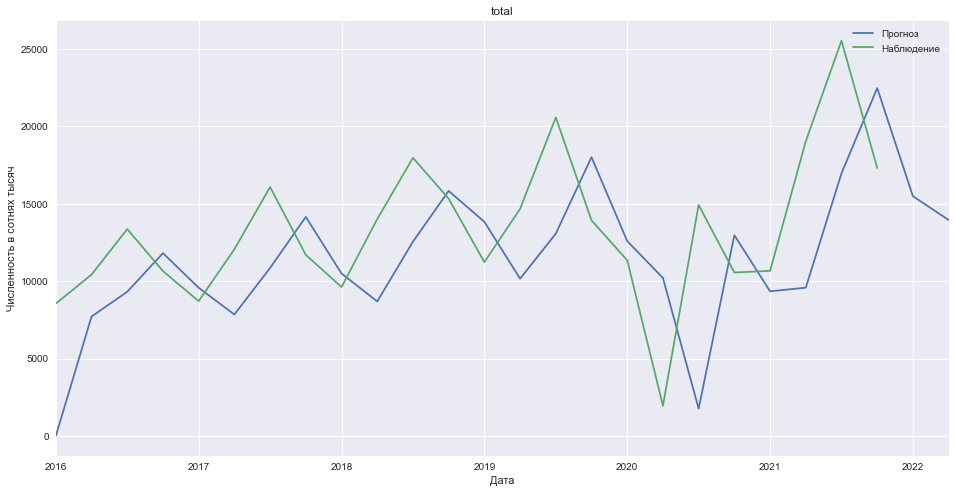

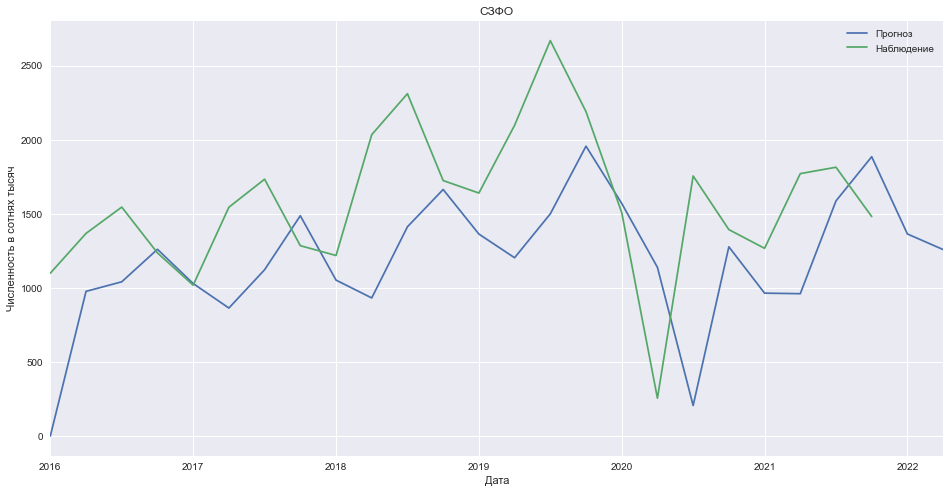

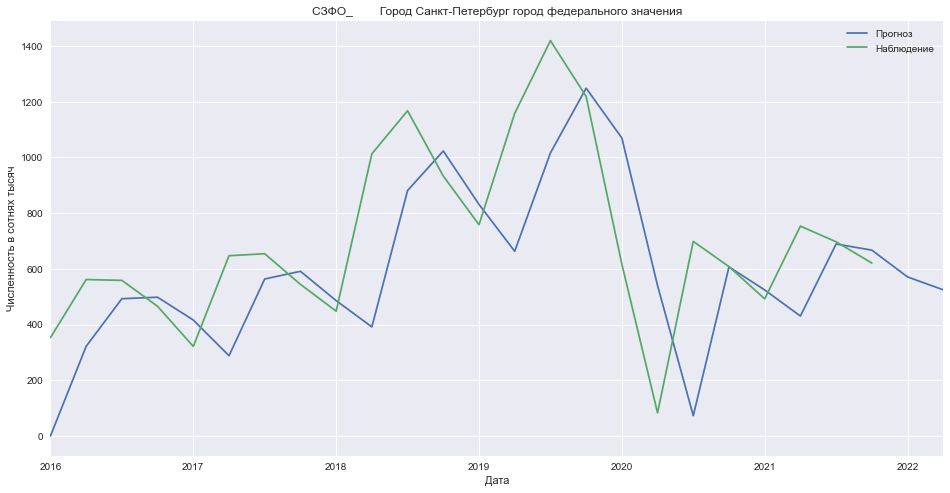

In [53]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'sarimax', 'WLSS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

## Prophet

### Bottom-Up Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [02:12<00:00,  1.46s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AF5FAC70>


MAE total: 1839.72
Прогнозы total: 2022-01-01    10188.92
2022-04-01     4820.43
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 533.04
Прогнозы СЗФО: 2022-01-01    641.76
2022-04-01     46.50
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 99.47
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01   -111.39
2022-04-01   -807.19
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


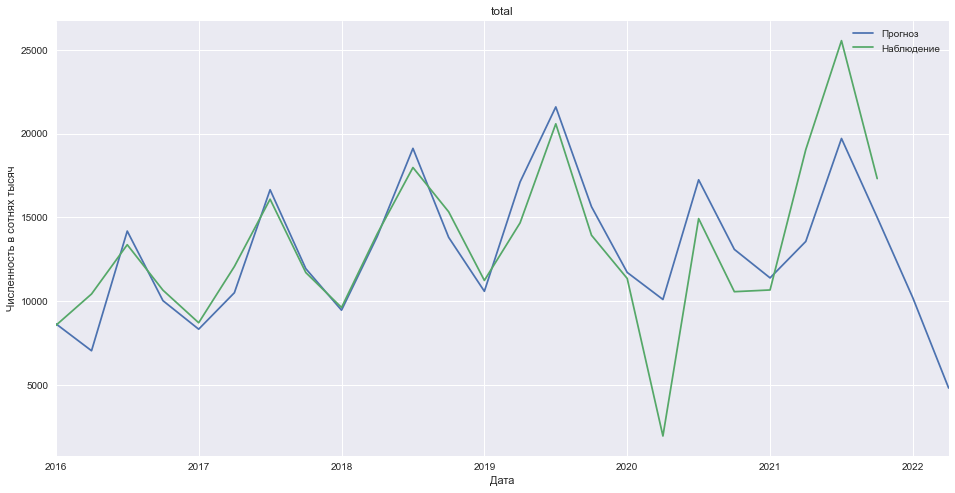

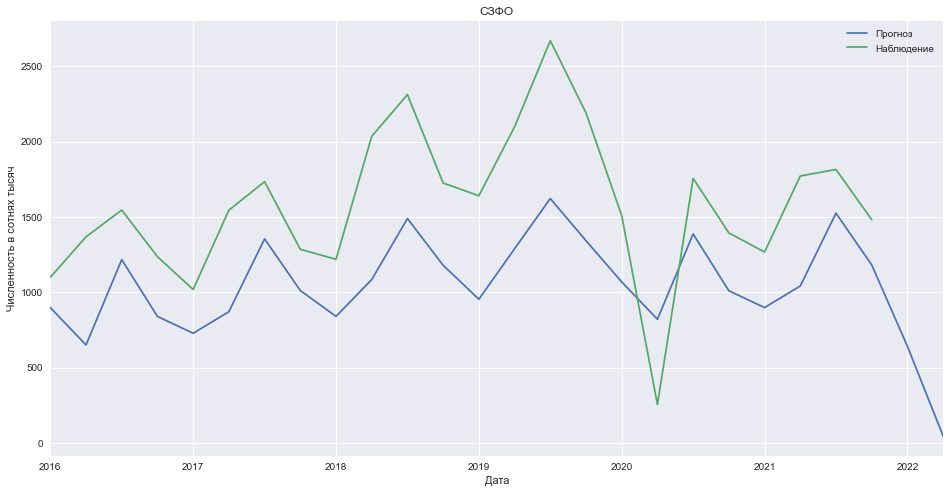

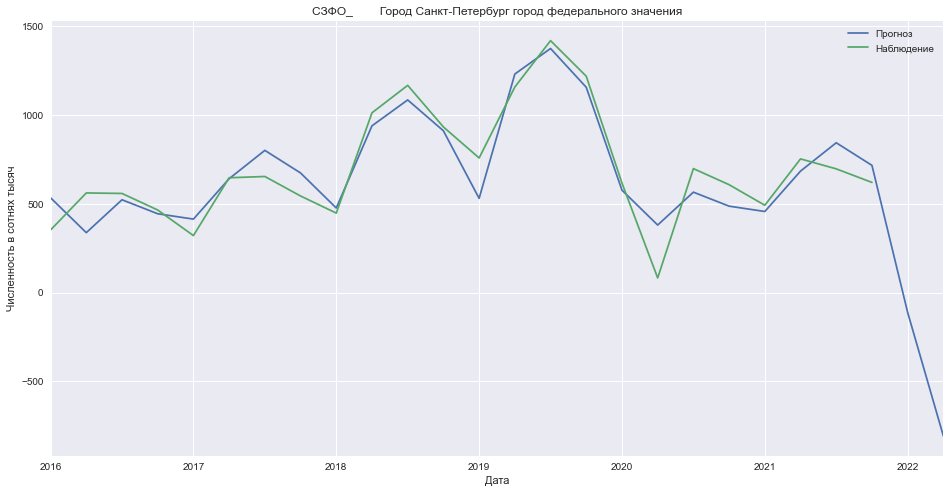

In [54]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'prophet', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [02:19<00:00,  1.53s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217A4AF5760>


MAE total: 1829.27
Прогнозы total: 2022-01-01    9529.89
2022-04-01    2367.59
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 517.06
Прогнозы СЗФО: 2022-01-01    794.89
2022-04-01    197.48
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 178.7
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01    498.66
2022-04-01    123.89
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


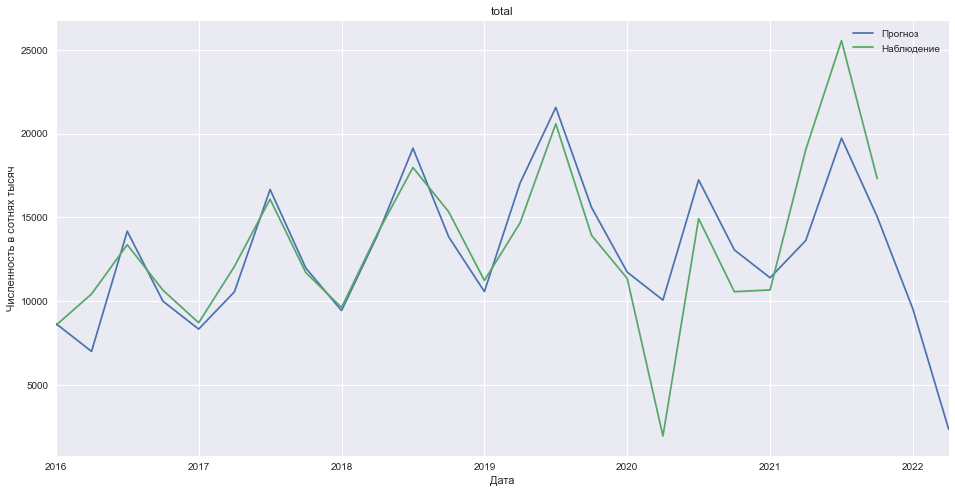

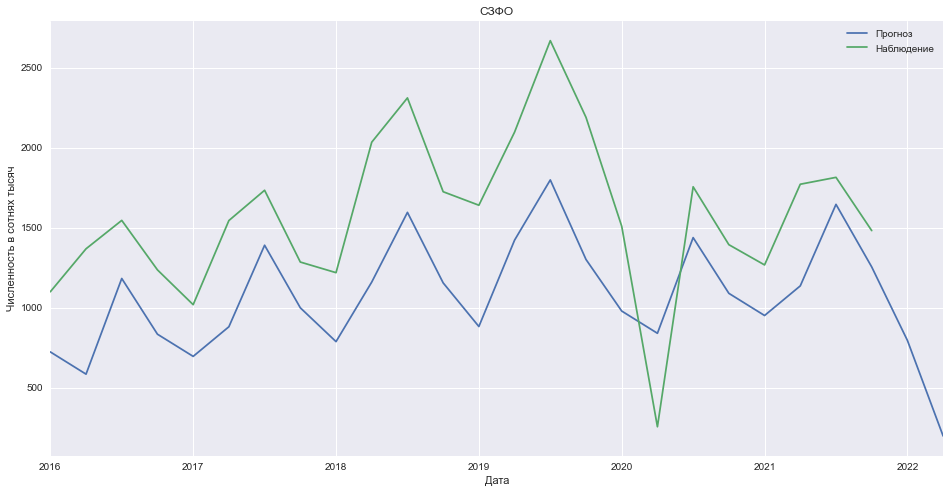

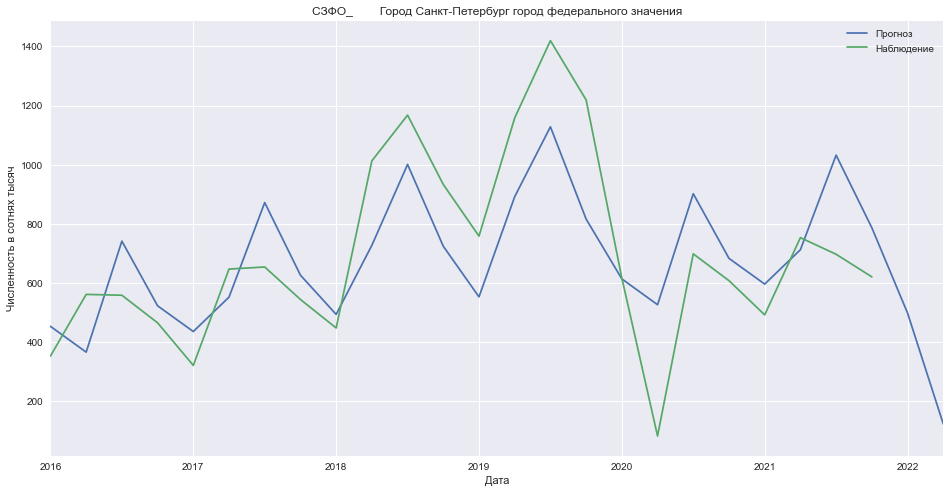

In [55]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'prophet', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [02:16<00:00,  1.50s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000217AF1EF730>


MAE total: 1833.52
Прогнозы total: 2022-01-01    9804.00
2022-04-01    3389.81
Freq: QS-JAN, Name: total, dtype: float64
MAE СЗФО: 300.0
Прогнозы СЗФО: 2022-01-01    557.97
2022-04-01   -227.49
Freq: QS-JAN, Name: СЗФО, dtype: float64
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 105.81
Прогнозы СЗФО_        Город Санкт-Петербург город федерального значения: 2022-01-01   -106.99
2022-04-01   -794.69
Freq: QS-JAN, Name: СЗФО_        Город Санкт-Петербург город федерального значения, dtype: float64


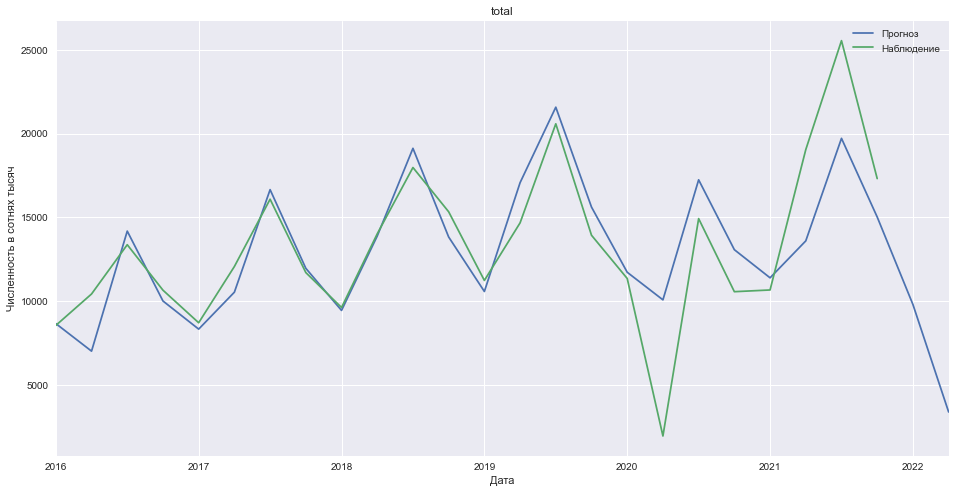

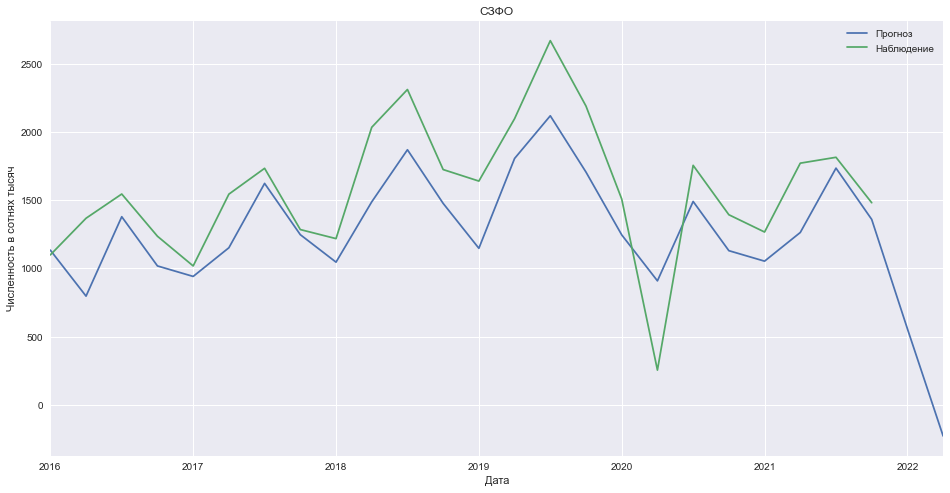

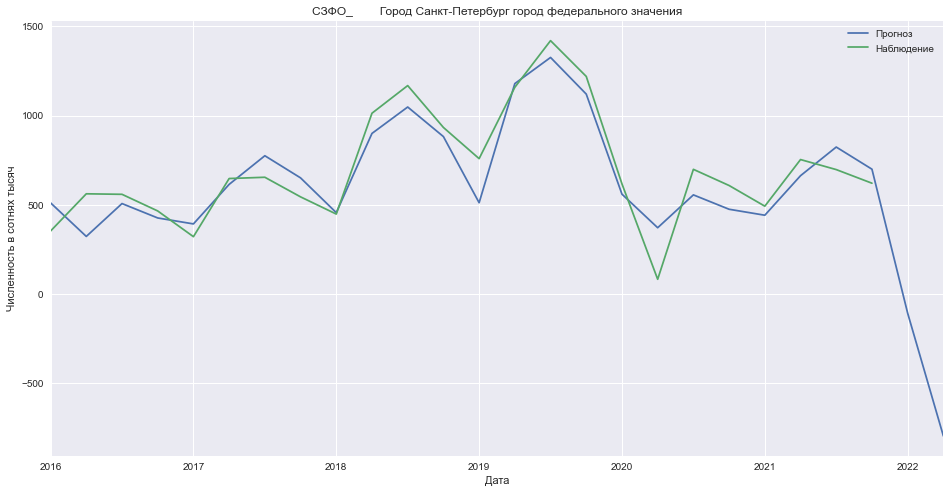

In [56]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'prophet', 'WLSS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])